In [2]:
# Import Python libraries (use Python >= v. 3.9.0)
#-------------------------------------------------

import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import zipfile
import folium
import geojson
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import networkx as nx
from pyrosm import OSM, get_data

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from descartes import PolygonPatch
from shapely.geometry import Point
from shapely.ops import cascaded_union

In [5]:
nodes, edges = OSM(get_data('Cambridge')).get_network(nodes = True)
G = OSM(get_data("Cambridge")).to_graph(nodes, edges, graph_type="networkx")

In [12]:
hospitals = pd.read_csv('cambridge_uni_hospital_sites.csv')
hospitals

,Code,Name,National Grouping,High Level Health Geography,Address Line 1,Address Line 2,Address Line 3,Address Line 4,Address Line 5,Postcode,Open Date,Close Date,Organisation Sub-Type Code,Parent Org Code
0,A6B3B,CUH AT MEADOWS COMMUNITY CENTRE,Y61,QUE,1 ST. CATHARINES ROAD,NaN,NaN,CAMBRIDGE,NaN,CB4 3XJ,20211001,NaN,NaN,RGT
1,A9J5N,CUH AT ROSMINI CENTRE,Y61,QUE,69A QUEENS ROAD,NaN,NaN,WISBECH,NaN,PE13 2PH,20220401,NaN,NaN,RGT
2,B1C9Z,CUH AT SPECSAVERS ROYSTON,Y61,QUE,27A-27B HIGH STREET,NaN,NaN,ROYSTON,NaN,SG8 9AA,20220401,NaN,NaN,RGT
3,B5D1I,CUH AT DODDINGTON HOSPITAL,Y61,QUE,BENWICK ROAD,DODDINGTON,NaN,MARCH,NaN,PE15 0UG,20210401,NaN,NaN,RGT
4,C5Z7J,CAMBRIDGE BIOMEDICAL RESEARCH CENTRE - VALNEVA...,Y61,QUE,HILLS ROAD,NaN,NaN,CAMBRIDGE,NaN,CB2 0QQ,20210401,NaN,NaN,RGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,RGT98,NUFFIELD HEALTH CAMBRIDGE HOSPITAL,Y61,QUE,4 TRUMPINGTON ROAD,NaN,NaN,CAMBRIDGE,CAMBRIDGESHIRE,CB2 8AF,20121001,NaN,NaN,RGT
174,RGT99,ST MARY'S SURGERY,Y61,QUE,37 ST. MARYS STREET,NaN,NaN,ELY,CAMBRIDGESHIRE,CB7 4HF,20121001,NaN,NaN,RGT
175,T4O3M,CUH AT COLCHESTER STARS,Y61,QUE,5A QUEEN STREET,NaN,NaN,COLCHESTER,NaN,CO1 2PG,20210401,NaN,NaN,RGT
176,T8C3T,CUH AT ROYAL PAPWORTH HOSPITAL,Y61,QUE,PAPWORTH ROAD,CAMBRIDGE BIOMEDICAL CAMPUS,NaN,CAMBRIDGE,NaN,CB2 0AY,20201001,NaN,NaN,RGT


/usr/local/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


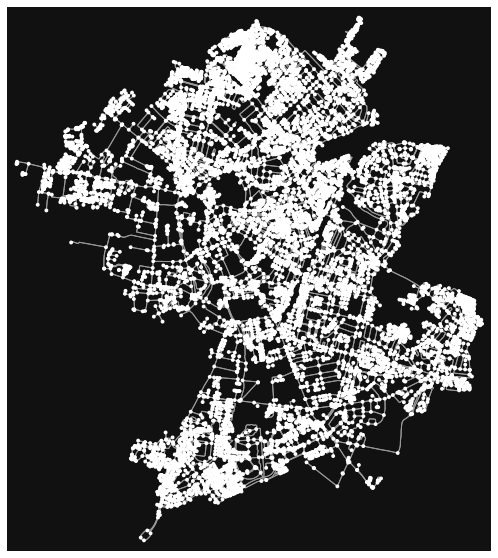

In [20]:

G = ox.graph.graph_from_place('Cambridge', simplify = True, network_type = 'walk')

# The following code can be run to decrease the time required to generate OSMnx network graphs.
# If a node cannot access at least 10% of other nodes it is removed from the network
#---------------------------------------------------------------------------------------

remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
     reach = len(nx.descendants(G, node))
     if reach < num_nodes / 10:
         remove_list.append(node)
for node in remove_list:
     G.remove_node(node)

#---------------------------------------------------------------------------------------
ox.plot_graph(G, figsize = (10,10));


In [27]:
#get the hospital details of 2 hospitals from the dataframe to compare location coverage scores with
hospital_t = hospitals.iloc[0]
hospital1_name = hospital_t['Name']
hospital1_address = hospital_t['Address Line 1'] + ', ' + 'Cambridge'
hospital1_geocode = ox.geocode(hospital1_address)
hospital1_node = ox.distance.get_nearest_node(G, hospital1_geocode)

hospital_s = hospitals.iloc[4]
hospital2_name = hospital_s['Name']
hospital2_address = hospital_s['Address Line 1'] + ', ' + 'Cambridge'
hospital2_geocode = ox.geocode(hospital2_address)
hospital2_node= ox.distance.get_nearest_node(G, hospital2_geocode)
#source_hospital = ox.distance.get_nearest_node(G_heartlands, [52.4786219775871, -1.8288765613718057])
print('the nearest node for hospital 1 is: {}'.format(hospital1_node))
print('the nearest node for hospital 2 is: {}'.format(hospital2_node))

the nearest node for hospital 1 is: 8613287131
the nearest node for hospital 2 is: 1486045382


/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [286]:
# Add freeflow travel time as an edge attribute to the networkx map
#---------------------------------------------------------------------------------------

#G = ox.add_edge_speeds(G) #---- This imputes free-flow travel speeds for all edges via the mean maxspeed value of the edges (speed limit of the street).
'''
G = ox.speed.add_edge_travel_times(G, precision=1) #---- This adds free flow travel time as an edge attribute

maps = [G_leicester, G_heartlands]

for G in maps: 
    for u, v, k, data in G.edges(data = True, keys = True):
        data['time'] = data['length']/(data['speed_kph'] * (1000/60))

'''

In [28]:
trip_times = [20]

In [32]:
locations = [hospital1_node, hospital2_node]

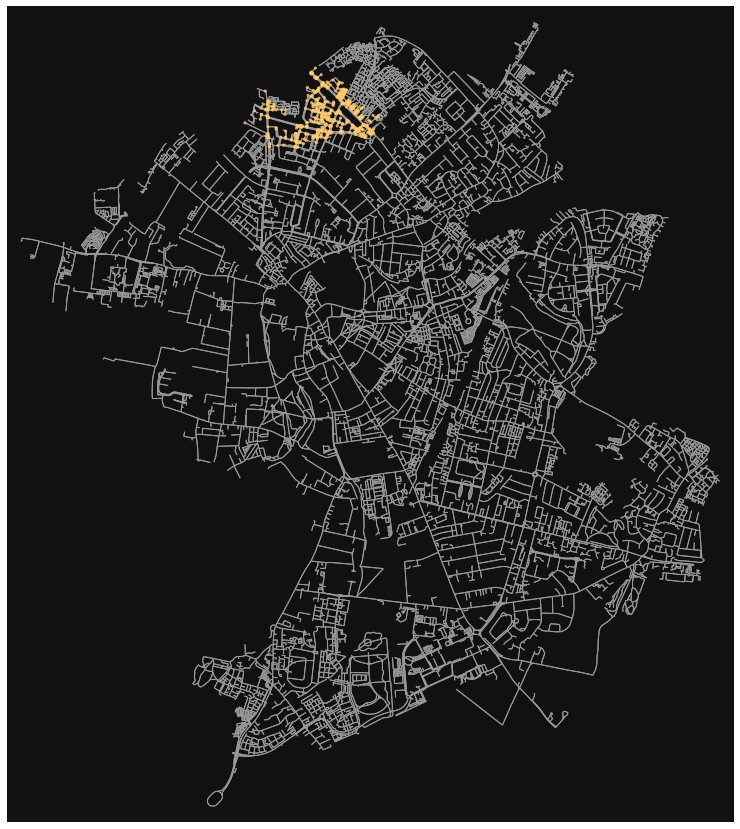

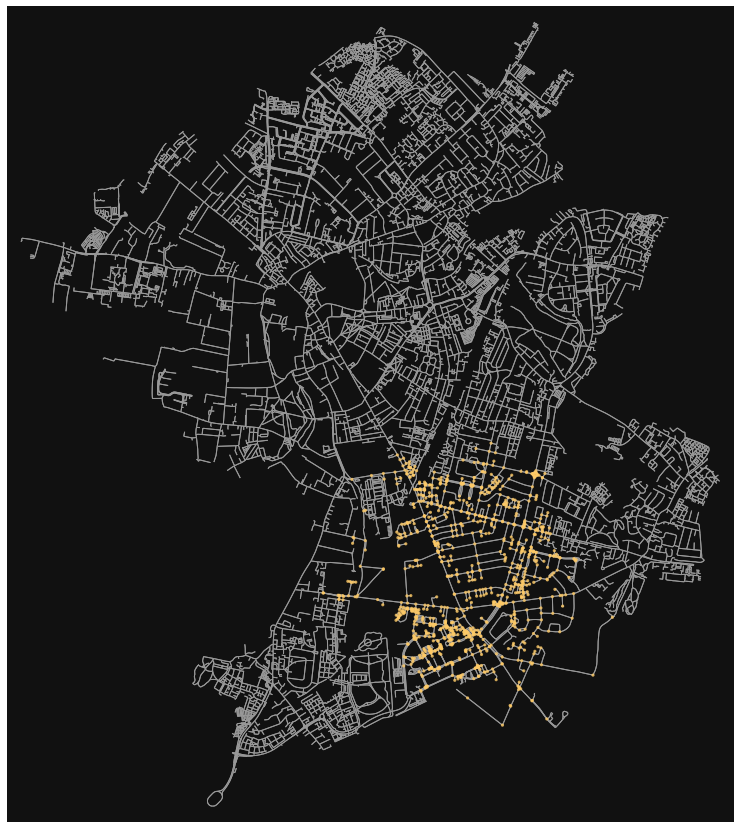

In [33]:
# Retrun one color for each isochrone (each of the trip times) 
#------------------------------------------------------------
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='YlOrRd', start=0.3, return_hex=True)

# Color the nodes according to isochrone then plot the urban network graph
#--------------------------------------------------------------------------
for points in locations:
    node_colors = {}
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time') #---- uses the edge attribute 'time' to define the isochrones for each of the trips
        for node in subgraph.nodes():
            node_colors[node] = color
    nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
    ns = [10 if node in node_colors else 0 for node in G.nodes()] #------ sets the size of the coloured nodes at '10', while uncoloured nodes (outside trip times) are not visualised
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2, figsize = (15,15))

/usr/local/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


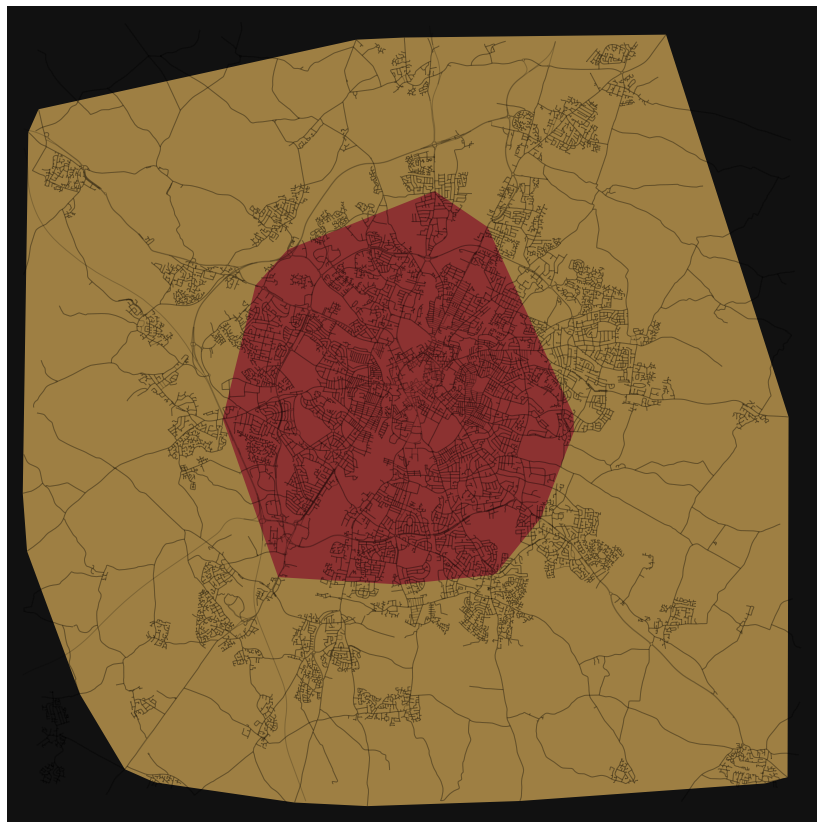

In [322]:
# Generate isochrone polygons for leicester
#--------------------------------------------------------------------------------------------------------------
isochrone_polys = []
trip_times = [7,15]
# Retrun one color for each isochrone (each of the trip times) 
#------------------------------------------------------------
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='YlOrRd', start=0.3, return_hex=True)
for trip_time in sorted(trip_times, reverse=True):
    isochrone_polys_sub = []
    subgraph = nx.ego_graph(G_leicester, point_leicester, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)] 
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys_sub.append(bounding_poly)
    isochrone_polys.append(isochrone_polys_sub)

# Plot the network then add isochrones as colored descartes polygon patches
#-----------------------------------------------------------------------
fig, ax = ox.plot_graph(G_leicester, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none', figsize = (15,15))
for polygon, fc in zip(isochrone_polys, iso_colors):
    for subpolygon in polygon:
        patch = PolygonPatch(subpolygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

In [323]:
trip_times = [7, 15, 30]
# Retrun one color for each isochrone (each of the trip times) 
#------------------------------------------------------------
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='YlOrRd', start=0.3, return_hex=True)
isochrone_polys_2 = []
for trip_time in sorted(trip_times, reverse=True):
    isochrone_polys_sub = []
    subgraph = nx.ego_graph(G_heartlands, point_heartlands, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)] 
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys_sub.append(bounding_poly)
    isochrone_polys_2.append(isochrone_polys_sub)


In [324]:
isochrone_polys_merged = [isochrone_polys, isochrone_polys_2]
isochrone_polys_merged

[[[<shapely.geometry.polygon.Polygon at 0x14b402760>],
 [[<shapely.geometry.polygon.Polygon at 0x1449d7e20>],

In [327]:
print(isochrone_polys_2)

[[<shapely.geometry.polygon.Polygon object at 0x1449d7e20>], [<shapely.geometry.polygon.Polygon object at 0x12f8d3910>], [<shapely.geometry.polygon.Polygon object at 0x140edb310>]]


/usr/local/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


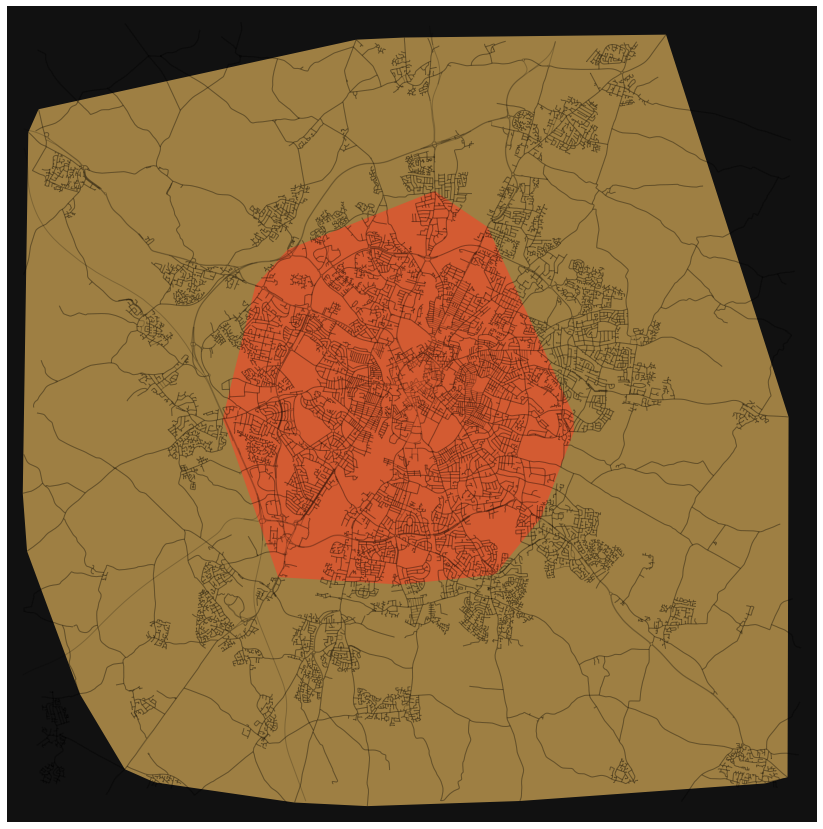

In [329]:
fig, ax = ox.plot_graph(G_leicester, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none', figsize = (15,15))
for polygon, fc in zip(isochrone_polys_merged[0], iso_colors):
    for subpolygon in polygon:
        patch = PolygonPatch(subpolygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

In [ ]:
for polys in isochrone_polys_merged[0]

In [288]:
# Generate isochrone polygons (convex hull) using GeoPandas and NetworkX for each of the GP practice isochrones 
#--------------------------------------------------------------------------------------------------------------
isochrone_polys = []
for G, point in zip(maps, pointers):
    isochrone_polys_sub = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, point, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)] 
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys_sub.append(bounding_poly)
    isochrone_polys.append(isochrone_polys_sub)
    
for G, polygon in zip(maps, isochrone_polys):
# Plot the network then add isochrones as colored descartes polygon patches
#-----------------------------------------------------------------------
    fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none', figsize = (15,15))
    for subpolygon, fc in zip(polygon, iso_colors):
        patch = PolygonPatch(subpolygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
    plt.show()


NodeNotFound: Node 1107509026 not found in graph

In [238]:
isochrone_polys[0]


In [330]:
addresses = [["Leicester Royal Infirmary", "Infirmary Square, Leicester, LE1 5WW", [52.62680134042248, -1.1349490962243667]], ["Birmingham Heartlands Hospital", "Bordesley Green E, Birmingham, B9 5SS", [52.4786219775871, -1.8288765613718057]]]

In [259]:
isochrone_polys

[[<shapely.geometry.polygon.Polygon at 0x139c2dcd0>,

In [346]:
len(style_geojson2)

3

In [501]:

# Generate three isochrone GeoJSON files representing the areas 5 minutes, 10 minutes, and 20 minutes walking distance from any of the central Cambridge GP practices
# from the ischrone polygons and add the to a folium map
#-------------------------------------------------------------------------------------------------
frame = folium.Figure(width=600, height=600)
folium_fig = folium.Map(
    location=[52.62680134042248, -1.1349490962243667],
    tiles="cartodbpositron",
    zoom_start=12).add_to(frame)

for add in addresses:
    folium.Marker(
        add[2],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + add[0] + '<br>'
        '<b>' + 'Address: ' + '</b>' + add[1] + '<br>'),
        icon=folium.Icon(color="#e8fc03", prefix='fa', icon="fa-ambulance"),
        ).add_to(folium_fig)

#Set the style for each of the ischrone geoJSONs
#--------------------------------------------------------
style_geojson1 = [
{'shape_name': '7 min Drive','shape_fillColor': '#003087'},
{'shape_name': '15 min Drive', 'shape_fillColor': '#005EB8'}]

style_geojson2 = [
{'shape_name': '7 min Drive','shape_fillColor': '#003087'},
{'shape_name': '15 min Drive', 'shape_fillColor': '#005EB8'},
{'shape_name': '30 min Drive', 'shape_fillColor': '#942f9c'}]
# From each of the isochrone polygons generate at geoJSON shapefile and add it to a folium map at the same time
#-------------------------------------------------------------------------------------------------------------

# From each of the isochrone polygons generate at geoJSON shapefile and add it to a folium map at the same time
#-------------------------------------------------------------------------------------------------------------
gdf_index = ['Leicester Infirmary', 'Birmingham Heartlands']
gdf = g

for site in gdf_index:
     for style, polygon in zip(style_geojson2, isochrone_polys_merged):
          gdf = gpd.GeoDataFrame({"Hospital Origin Site":gdf_index}, geometry = polygon)


for style, polygon in zip(style_geojson2, isochrone_polys_merged[1]):
     gdf = gpd.GeoDataFrame({"Hospital Origin Site": gdf_index}, geometry= polygon)
     polygon_json2 = list(gdf['geometry'])
     geojson2 = gpd.GeoSeries(cascaded_union(polygon_json2)).to_json()
     fillColor = style['shape_fillColor']
     shape_name = style['shape_name']
     folium.GeoJson(geojson2, name = shape_name, style_function = lambda x, fillColor = fillColor: {
          "fillColor": fillColor,
          "name":  shape_name,
          "weight": 1,
          "fillOpacity": 0.5,
          "color": "#000000"
          }).add_to(folium_fig)


for style, polygon in zip(style_geojson1, isochrone_polys_merged[0]):
     gdf1 = gpd.GeoDataFrame({"Hospital Origin Site": gdf_index}, geometry= polygon)
     polygon_json1 = list(gdf1['geometry'])
     geojson1 = gpd.GeoSeries(cascaded_union(polygon_json1)).to_json()
     fillColor = style['shape_fillColor']
     shape_name = style['shape_name']
     folium.GeoJson(geojson1, name = shape_name, style_function = lambda x, fillColor = fillColor: {
          "fillColor": fillColor,
          "name":  shape_name,
          "weight": 1,
          "fillOpacity": 0.5,
          "color": "#000000"
          }).add_to(folium_fig)
folium.LayerControl().add_to(folium_fig)
#Saves the folium map as an html object for use in the webpage
#--------------------------------------------------------------
folium_fig

/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_5609/2237081100.py:15: UserWarning: color argument of Icon should be one of: {'darkred', 'black', 'green', 'beige', 'lightgreen', 'red', 'lightred', 'darkgreen', 'orange', 'lightblue', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'blue', 'purple', 'lightgray', 'pink', 'gray'}.
  icon=folium.Icon(color="#e8fc03", prefix='fa', icon="fa-ambulance"),
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_5609/2237081100.py:40: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  geojson2 = gpd.GeoSeries(cascaded_union(polygon_json2)).to_json()
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_5609/2237081100.py:40: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  geojson2 = gpd.GeoSeries(cascaded_union(polygon_json2)).to_json()
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_5609/2237081100.py:40: S

In [507]:
gdf_index = ['Leicester Infirmary', 'Birmingham Heartlands']
gdf = gpd.GeoDataFrame({"Hospital Origin Site" : gdf_index})


,Hospital Origin Site
0,Leicester Infirmary
1,Birmingham Heartlands


In [518]:
gdf["geometry"] = isochrone_polys_merged


/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [519]:
gdf

,Hospital Origin Site,geometry
0,Leicester Infirmary,"[[POLYGON ((-1.1528807 52.5309738, -1.1820864 ..."
1,Birmingham Heartlands,"[[POLYGON ((-1.9304469 52.2987968, -1.9399721 ..."


In [ ]:
geom = []
for i in isochrone_polys_merged[1]:
    for j in i:
        geom.append(j)
geom

names = ["L", "B"]
polys = isochrone_polys_merged

In [486]:

gdf = gpd.GeoDataFrame({"Hospital Origin Site" : ["Birmingham"]}, geometry  = isochrone_polys_merged[1][0])

In [482]:
res

0    POLYGON ((-1.15288 52.53097, -1.18209 52.53185...
0    POLYGON ((-1.93045 52.29880, -1.93997 52.29880...
Name: geometry, dtype: geometry

In [488]:

polygon_json = list(result['geometry'])
geojson = gpd.GeoSeries(cascaded_union(polygon_json)).to_json()
fillColor = style['shape_fillColor']
shape_name = style['shape_name']
folium.GeoJson(geojson, name = shape_name, style_function = lambda x, fillColor = fillColor: {
"fillColor": fillColor,
"name":  shape_name,
"weight": 1,
"fillOpacity": 0.5,
"color": "#000000"
}).add_to(folium_fig)
folium.LayerControl().add_to(folium_fig)


#Saves the folium map as an html object for use in the webpage
#--------------------------------------------------------------
folium_fig


/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_5609/223944848.py:2: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  geojson = gpd.GeoSeries(cascaded_union(polygon_json)).to_json()


In [479]:
folium_fig

In [444]:
gdf['geometry'][1] = geom

In [446]:
polygon_json = list(gdf['geometry'])[1]

In [447]:
gdf['geometry'][]

In [448]:
fillColor = style['shape_fillColor']
shape_name = style['shape_name']
folium.GeoJson(geojson, name = shape_name, style_function = lambda x, fillColor = fillColor: {
"fillColor": fillColor,
"name":  shape_name,
"weight": 1,
"fillOpacity": 0.5,
"color": "#000000"
}).add_to(folium_fig)
folium.LayerControl().add_to(folium_fig)


#Saves the folium map as an html object for use in the webpage
#--------------------------------------------------------------
folium_fig
gdf


#Saves the folium map as an html object for use in the webpage
#--------------------------------------------------------------
folium_fig